In [ ]:
%load_ext autoreload
%autoreload 2
import os
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"
import jax, optax, pickle, argparse
from jax import numpy as jnp
from flax import nnx
from models import LeNet, ResNet
from fedflax import train, aggregate
from data import get_gaze
from functools import reduce
from matplotlib import pyplot as plt
from utils import *

# Experiment hyperparameters
parser = argparse.ArgumentParser(description="Set experiment parameters")
parser.add_argument("--clf", action="store_true", help="Specify for classification instead of regression")
parser.add_argument("--asym", type=str, choices=["w", "s", "d"], default="w", help="Asymmetry type. Options: 'w(asym)' | 's(yre)' | 'd(imexp)'")
parser.add_argument("--model_class", type=str, default="LeNet", help="Model class. Options: 'LeNet' | 'ResNet'")
args = parser.parse_args([])
clf = args.clf
asym = args.asym
model_class = LeNet if args.model_class == "LeNet" else ResNet

## Setup

In [ ]:
# Set up loss functions depending on task
if clf:
    ell = return_ce(0.)
    val_fn = err_fn
else:
    ell = return_l2(0.)
    val_fn = angle_err

# Data 
ds_train = get_gaze(beta=1., skew="feature", clf=clf)
ds_val = get_gaze(partition="val", beta=1., batch_size=32, skew="feature", clf=clf)
ds_test = get_gaze(partition="test", beta=1., batch_size=16, skew="feature", clf=clf)

# Determine asym extent values
pfixes = jnp.linspace(1., 0., 21).round(3).tolist()
sigmas = ((1 - jnp.log(jnp.linspace(jnp.e, 1, 20))) * 1/jnp.sqrt(158554)).tolist()
asym_extents = sigmas if asym=="s" else pfixes if asym=="w" else [0., 1.]

# Utility to set up model depending on asymmetry type
def get_model(extent):
    dim_out = 9 if clf else 2
    sigma = 0. if asym!="s" else extent
    pfix = 1. if asym!="w" else extent
    dimexp = False if asym!="d" else bool(extent) 
    return model_class(jax.random.key(42), pfix=pfix, syre_sigma=sigma, dim_out=dim_out, dimexp=dimexp)

## Check metrics
Available techniques are dimension expansion and W-Asymmetry, of which the latter is implemented here.

In [ ]:
def angle(updates):
    update_g = jax.tree.map(lambda updates: jnp.mean(updates, axis=0), updates)
    update_g = jnp.concatenate([jnp.ravel(x) for x in update_g])
    updates_flat = jnp.concatenate(jax.tree.map(lambda x: jnp.reshape(x, (4,-1)), updates), axis=1)
    for update in updates_flat:
        angle = jnp.degrees(jnp.arccos(optax.losses.cosine_similarity(update_g, update))).item()
    return angle

metrics = {"angle":[], "err":[]}
for extent in asym_extents:
    # Train
    model = get_model(extent)
    updates, _ = train(model, opt_create, ds_train, ds_val, ell, local_epochs=20, rounds=1, val_fn=val_fn)
    # Aggregate
    model_g = aggregate(model, updates)
    # Average accuracy on local data
    vval_fn = nnx.jit(nnx.vmap(val_fn, in_axes=(None,0,0,0)))
    err = reduce(lambda e, batch: e + vval_fn(model_g,*batch), ds_test, 0.) / len(ds_test)
    metrics["err"].append(err)
    # Angle
    metrics["angle"].append(angle(jax.tree.leaves(updates)))
pickle.dump(metrics, open(f"break/break_metrics_{clf=}_{asym=}_{args.model_class}.pkl", "wb"))

## Visualize

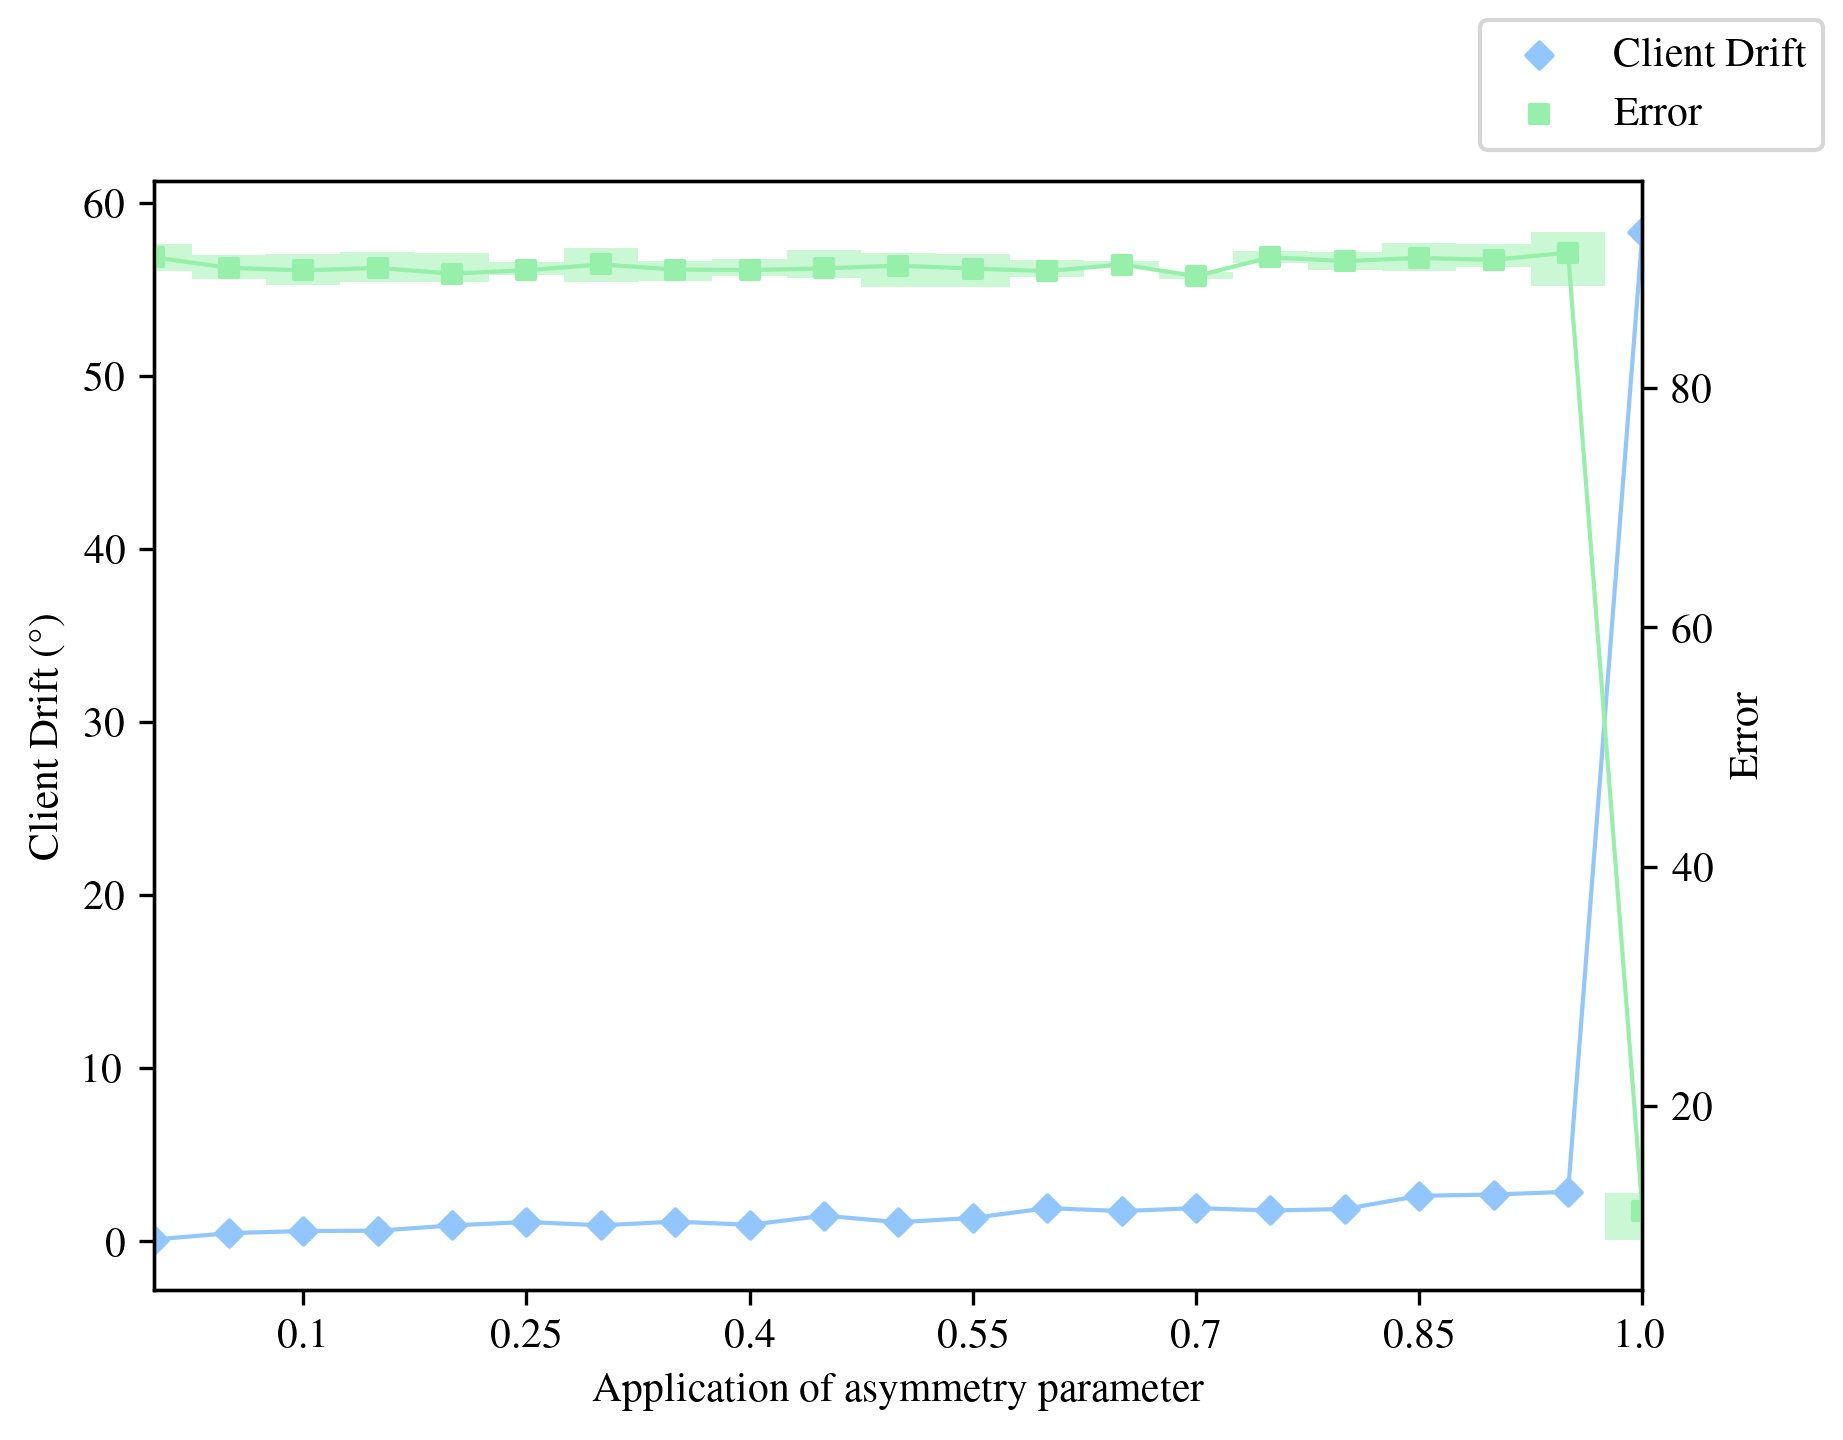

In [25]:
# Rendering style
plt.style.use("seaborn-v0_8-pastel")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.sans-serif": ["Helvetica"],
    "text.latex.preamble": r"""
        \usepackage{amsmath, amssymb}
        \usepackage{mathptmx} 
    """
})

metrics = pickle.load(open(f"break/break_metrics_{clf=}_{asym=}_{args.model_class}.pkl", "rb"))

# Scatter angles
fig, ax1 = plt.subplots(dpi=300);
ax1.scatter(asym_extents, metrics["angle"], color="C0", label="Client Drift", marker="D", s=20)
ax1.plot(asym_extents, metrics["angle"], color="C0", linewidth=1)
ax1.set_ylabel("Client Drift (°)")

# New axis for error boxplots
err = jnp.array(metrics["err"])
ax2 = ax1.twinx();
ax2.scatter(asym_extents, err.mean(axis=1), color="C1", label="Error", marker="s", s=20)
ax2.plot(asym_extents, err.mean(axis=1), color="C1", linewidth=1)
ax2.fill_between(asym_extents, err.min(1), err.max(1), color="C1", alpha=0.5, step="mid", linewidth=0)
ax2.set_ylabel("Error")

# Final touches
ax1.set_xlim(min(asym_extents), max(asym_extents))
ax1.set_xticks(asym_extents[::3])
ax1.set_xticklabels(ax1.get_xticks().round(4))
ax1.set_xlabel("Application of asymmetry parameter")
fig.legend()
fig.savefig(f"break/break_{clf=}_{asym=}_model={args.model_class}.png", bbox_inches="tight")